In [1]:
fff=!pwd
print(fff[0]+"/create_SIDER_side_effect_data.ipynb")

/workspace/02_cha_drug_repositioning/create_SIDER_side_effect_data.ipynb


In [2]:
%load_ext autoreload
%autoreload 2

# Imports

In [4]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from cmapPy.pandasGEXpress.parse import parse
from cmapPy.pandasGEXpress.write_gct import write
from cmapPy.pandasGEXpress.GCToo import GCToo
from cmapPy.pandasGEXpress.gctx2gct import gctx2gct_main

import torch

import warnings
warnings.filterwarnings('ignore')

In [5]:
from super_classes import param_class as param_class_module
from utils import data_processing as data_processing_module
from utils import data_load as data_load_module
from run import train as train_module
from run import test_model as test_model_module

# Configure parameters

In [6]:
BASE_DIR="/workspace/datafiles/2023/04/02_cha_drug_repositioning/paper_data"
GCTX_PATH_GSE70138="GSE70138_Broad_LINCS_Level4_ZSPCINF_mlr12k_n345976x12328_2017-03-06.gctx"
GCTX_PATH_GSE92742="GSE92742_Broad_LINCS_Level4_ZSPCINF_mlr12k_n1319138x12328.gctx"
TXT_META_PATH_GSE70138="GSE70138_Broad_LINCS_inst_info_2017-03-06.txt"
TXT_META_PATH_GSE92742="GSE92742_Broad_LINCS_inst_info.txt"
PERT_META_PATH_GSE70138="GSE70138_Broad_LINCS_pert_info_2017-03-06.txt"
PERT_META_PATH_GSE92742="GSE92742_Broad_LINCS_pert_info.txt"
TXT_LANDMARK_GENES_PATH="GSE92742_Broad_LINCS_gene_info_delta_landmark.txt"

Sent_FC_data="/workspace/datafiles/2023/04/02_cha_drug_repositioning/sent_data/DEG/GSE33814.csv"

In [7]:
configurable_parameters_dict={
  "BASE_DIR":BASE_DIR,
  "GCTX_PATH_GSE70138":GCTX_PATH_GSE70138,
  "GCTX_PATH_GSE92742":GCTX_PATH_GSE92742,
  "TXT_META_PATH_GSE70138":TXT_META_PATH_GSE70138,
  "TXT_META_PATH_GSE92742":TXT_META_PATH_GSE92742,
  "PERT_META_PATH_GSE70138":PERT_META_PATH_GSE70138,
  "PERT_META_PATH_GSE92742":PERT_META_PATH_GSE92742
}

In [8]:
current_drug="donepezil" # donepezil, galantamine, memantine

# Load data

In [9]:
df_drug_names=pd.read_csv("/workspace/02_cha_drug_repositioning/datafiles/drug_names.tsv",encoding='utf-8',sep='\t',names=['drug_id','drug_name'])
df_meddra_all_label_se=pd.read_csv("/workspace/02_cha_drug_repositioning/datafiles/meddra_all_label_se.tsv",encoding='utf-8',sep='\t',names=['Col1','drug_id','drug_id2','Col2','Col3','Col4','side_effect'])

df_SAEDR=pd.read_csv("/workspace/02_cha_drug_repositioning/datafiles/SAEDR_scores_2021_02_02.csv",encoding='utf-8',sep=',')
df_DRIP=pd.read_csv("/workspace/02_cha_drug_repositioning/datafiles/DRIP_scores_2021_02_02.csv",encoding='utf-8',sep=',')

<AxesSubplot:>

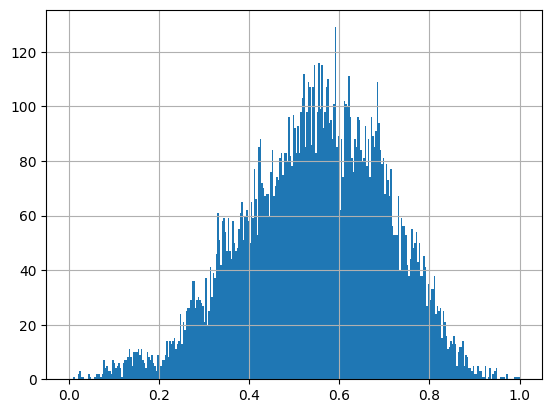

In [10]:
df_SAEDR['saedr_score'].hist(bins=300)

In [11]:
df_SAEDR

,cui,pt_code,adr,saedr_score,saedr_score_std
0,C1277265,10014190,dry eczema,0.000000,0.064295
1,C3854465,10075267,skin texture abnormal,0.011522,0.070970
2,C0392162,10051788,sticky skin,0.020100,0.068578
3,C0235218,10040952,skin warm,0.021540,0.076752
4,C0235967,10042652,sweat discolouration,0.024905,0.070746
...,...,...,...,...,...
12193,C1112466,10056237,migrainous infarction,0.971265,0.080278
12194,C0021308,10061216,infarction,0.988595,0.086387
12195,C0333549,10019013,haemorrhagic infarction,0.990397,0.074039
12196,C0340324,10049768,silent myocardial infarction,0.996127,0.097390


In [12]:
def saedr_level_labeler(saedr_value):
  if saedr_value<0.25:
    return "L1"
  elif 0.25<=saedr_value<0.5:
    return "L2"
  elif 0.5<=saedr_value<0.75:
    return "L3"
  elif 0.75<=saedr_value:
    return "L4"
df_SAEDR['saedr_level']=df_SAEDR['saedr_score'].apply(saedr_level_labeler)
df_SAEDR

,cui,pt_code,adr,saedr_score,saedr_score_std,saedr_level
0,C1277265,10014190,dry eczema,0.000000,0.064295,L1
1,C3854465,10075267,skin texture abnormal,0.011522,0.070970,L1
2,C0392162,10051788,sticky skin,0.020100,0.068578,L1
3,C0235218,10040952,skin warm,0.021540,0.076752,L1
4,C0235967,10042652,sweat discolouration,0.024905,0.070746,L1
...,...,...,...,...,...,...
12193,C1112466,10056237,migrainous infarction,0.971265,0.080278,L4
12194,C0021308,10061216,infarction,0.988595,0.086387,L4
12195,C0333549,10019013,haemorrhagic infarction,0.990397,0.074039,L4
12196,C0340324,10049768,silent myocardial infarction,0.996127,0.097390,L4


In [13]:
df_DRIP.head(3)

,cid,drug,n_adrs,drip_mean,drip_std
0,CID100216416,lasofoxifene,299,0.779614,0.023316
1,CID100060795,aripiprazole,684,2.373446,0.035455
2,CID100001690,doxorubicin,399,3.799290,0.105105


In [14]:
df_DRIP=df_DRIP.sort_values(by=['drip_mean'], axis=0, ascending=False)
df_DRIP.head(3)

,cid,drug,n_adrs,drip_mean,drip_std
872,CID100005372,tacrolimus,454,10.359589,0.317855
4,CID100004666,paclitaxel,360,9.408383,0.494878
16,CID100004271,mycophenolate,395,8.617460,0.026517


In [15]:
df_DRIP=df_DRIP.drop_duplicates(subset=['drug'],keep='first')
df_DRIP.head(3)

,cid,drug,n_adrs,drip_mean,drip_std
872,CID100005372,tacrolimus,454,10.359589,0.317855
4,CID100004666,paclitaxel,360,9.408383,0.494878
16,CID100004271,mycophenolate,395,8.617460,0.026517


In [16]:
df_drug_names.head(3)

,drug_id,drug_name
0,CID100000085,carnitine
1,CID100000119,gamma-aminobutyric
2,CID100000137,5-aminolevulinic


In [17]:
df_DRIP_df_SIDER=df_DRIP.merge(df_drug_names,left_on='cid',right_on='drug_id',how='inner')
drugs_and_drip_regarding_sider=df_DRIP_df_SIDER[['drug_name','drip_mean']]
drugs_and_drip_regarding_sider

,drug_name,drip_mean
0,tacrolimus,10.359589
1,paclitaxel,9.408383
2,mycophenolate,8.617460
3,mycophenolic,8.499163
4,retinoic,7.542281
...,...,...
930,flurandrenolone,0.010658
931,lindane,0.007364
932,isosulfan,0.005526
933,sertaconazole,0.004849


In [18]:
df_meddra_all_label_se

,Col1,drug_id,drug_id2,Col2,Col3,Col4,side_effect
0,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,LLT,C0000737,Abdominal pain
1,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0000737,Abdominal pain
2,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0687713,Gastrointestinal pain
3,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,LLT,C0002170,Alopecia
4,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,PT,C0002170,Alopecia
...,...,...,...,...,...,...,...
4753136,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,LLT,C1565489,Renal impairment
4753137,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C0035078,Renal failure
4753138,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C1565489,Renal impairment
4753139,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1608945,LLT,C1608945,Exfoliative rash


In [19]:
side_effect_and_code_table_from_SIDER=df_meddra_all_label_se[["Col4","side_effect"]].drop_duplicates(keep='first')
side_effect_and_code_table_from_SIDER

,Col4,side_effect
0,C0000737,Abdominal pain
2,C0687713,Gastrointestinal pain
3,C0002170,Alopecia
5,C0002395,Dementia Alzheimer's type
7,C0002622,Amnesia
...,...,...
4605215,C0003119,Anophthalmos
4699371,C0022541,Kearns-Sayre syndrome
4699455,C0562483,Persistent cough
4708128,C0424444,Teeth clenching


In [20]:
joint_data=df_meddra_all_label_se.merge(df_drug_names,left_on='drug_id',right_on='drug_id',how='left')
joint_data

,Col1,drug_id,drug_id2,Col2,Col3,Col4,side_effect,drug_name
0,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,LLT,C0000737,Abdominal pain,lasofoxifene
1,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0000737,Abdominal pain,lasofoxifene
2,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0687713,Gastrointestinal pain,lasofoxifene
3,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,LLT,C0002170,Alopecia,lasofoxifene
4,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,PT,C0002170,Alopecia,lasofoxifene
...,...,...,...,...,...,...,...,...
4753136,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,LLT,C1565489,Renal impairment,tenofovir
4753137,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C0035078,Renal failure,tenofovir
4753138,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C1565489,Renal impairment,tenofovir
4753139,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1608945,LLT,C1608945,Exfoliative rash,tenofovir


In [21]:
df_side_effect=joint_data.drop_duplicates(subset=["side_effect","drug_name"],keep='first')
df_side_effect

,Col1,drug_id,drug_id2,Col2,Col3,Col4,side_effect,drug_name
0,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,LLT,C0000737,Abdominal pain,lasofoxifene
2,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0687713,Gastrointestinal pain,lasofoxifene
3,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,LLT,C0002170,Alopecia,lasofoxifene
5,EMA/WC500020092.html,CID100216416,CID000216416,C0002395,LLT,C0002395,Dementia Alzheimer's type,lasofoxifene
7,EMA/WC500020092.html,CID100216416,CID000216416,C0002622,LLT,C0002622,Amnesia,lasofoxifene
...,...,...,...,...,...,...,...,...
4753079,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0033771,LLT,C0033771,Prurigo,tenofovir
4753117,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0221201,LLT,C0221201,Rash macular,tenofovir
4753119,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0221203,LLT,C0221203,Rash vesicular,tenofovir
4753130,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0497365,LLT,C0497365,Rash generalised,tenofovir


In [22]:
all_side_effect=list(df_side_effect['side_effect'].unique())
all_side_effect.sort()
all_side_effect[:10]

["5'nucleotidase increased",
 'AGEP',
 'AIDS dementia complex',
 'AION',
 'AML progression',
 'ANA increased',
 'Abasia',
 'Abdominal abscess',
 'Abdominal adhesions',
 'Abdominal aortic aneurysm']

In [23]:
all_drugs=df_side_effect['drug_name'].unique()
all_drugs.sort()
all_drugs[:10]

array(['1,25(OH)2D3', '17-hydroxyprogesterone', '18F-FDG',
       '18F-flutemetamol', '2-hydroxysuccinaldehyde', '4-AP', '4-PBA',
       '4-methylpyrazole', '5-ASA', '5-FU'], dtype=object)

In [24]:
def loop_many(count_by_id_drugname):
  out_df=[]
  for idx,one_drug in tqdm(enumerate(count_by_id_drugname)):
    in_dict={}
    selected=df_side_effect[df_side_effect['drug_name']==one_drug]
    selected_side_effect=set(selected['side_effect'])
    in_dict['drug_name']=one_drug
    for one_side_effect in all_side_effect:
      if one_side_effect in list(set(all_side_effect).intersection(selected_side_effect)):
        in_dict[one_side_effect]=1
      else:
        in_dict[one_side_effect]=0
    in_df=pd.DataFrame(in_dict,index=[idx])
    out_df.append(in_df)
  return out_df

In [25]:
import multiprocessing

pool = multiprocessing.Pool(processes=74) # 현재 시스템에서 사용 할 프로세스 개수

df_split = np.array_split(all_drugs, 74)

bbb=pool.map(loop_many,df_split)
pool.close()
pool.join()

18it [00:51,  2.88s/it]
18it [00:52,  2.91s/it]
18it [00:53,  2.99s/it]
18it [00:54,  3.02s/it]
18it [00:55,  3.08s/it]
14it [00:55,  3.42s/it]
18it [00:56,  3.12s/it]
19it [00:57,  3.04s/it]
18it [00:58,  3.22s/it]
18it [00:59,  3.28s/it]
18it [00:59,  3.28s/it]
18it [00:59,  3.29s/it]
19it [00:59,  3.14s/it]
18it [01:00,  3.33s/it]
18it [01:00,  3.36s/it]
18it [01:01,  3.43s/it]
18it [01:02,  3.45s/it]
18it [01:04,  3.58s/it]
18it [01:05,  3.62s/it]
18it [01:05,  3.63s/it]
18it [01:05,  3.65s/it]
18it [01:06,  3.72s/it]
19it [01:07,  3.56s/it]
18it [01:07,  3.77s/it]
18it [01:07,  3.77s/it]
18it [01:08,  3.79s/it]
18it [01:08,  3.83s/it]
18it [01:09,  3.84s/it]
18it [01:09,  3.85s/it]
18it [01:09,  3.85s/it]
19it [01:09,  3.66s/it]
19it [01:09,  3.66s/it]
19it [01:09,  3.67s/it]
18it [01:09,  3.87s/it]
18it [01:09,  3.87s/it]
18it [01:09,  3.89s/it]
18it [01:10,  3.89s/it]
18it [01:10,  3.89s/it]
18it [01:10,  3.91s/it]
18it [01:10,  3.92s/it]
18it [01:10,  3.93s/it]
18it [01:10,  3.

In [26]:
df_list_collected=[]
for one_bbb in bbb:
  df_list_collected.append(pd.concat(one_bbb))

In [27]:
drug_side_effect_df=pd.concat(df_list_collected)
drug_side_effect_df

,drug_name,5'nucleotidase increased,AGEP,AIDS dementia complex,AION,AML progression,ANA increased,Abasia,Abdominal abscess,Abdominal adhesions,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
0,"1,25(OH)2D3",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17-hydroxyprogesterone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18F-FDG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18F-flutemetamol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2-hydroxysuccinaldehyde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,zolmitriptan,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
14,zolpidem,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15,zonisamide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,zopiclone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
drug_side_effect_df=drug_side_effect_df.set_index('drug_name')
drug_side_effect_df

,5'nucleotidase increased,AGEP,AIDS dementia complex,AION,AML progression,ANA increased,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal aortic aneurysm,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
drug_name,,,,,,,,,,,,,,,,,,,,,
"1,25(OH)2D3",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17-hydroxyprogesterone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-FDG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-flutemetamol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-hydroxysuccinaldehyde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolmitriptan,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zolpidem,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zonisamide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
sorted_drug_side_effect_df=drug_side_effect_df[sorted(drug_side_effect_df.columns)]
sorted_drug_side_effect_df

,5'nucleotidase increased,AGEP,AIDS dementia complex,AION,AML progression,ANA increased,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal aortic aneurysm,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
drug_name,,,,,,,,,,,,,,,,,,,,,
"1,25(OH)2D3",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17-hydroxyprogesterone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-FDG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-flutemetamol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-hydroxysuccinaldehyde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolmitriptan,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zolpidem,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zonisamide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_candidates_filtered_by_DEG_agnostic=pd.read_csv("./result_files/find_drugs_acting_agnostic_to_DEG/candidates_filtered_by_DEG_agnostic_{}_CRTAP.csv".format(current_drug),encoding='utf-8')
df_candidates_filtered_by_DEG_agnostic

,filtered_drug,filtered_drug_expression,filtered_drug_threshold,current_drug,DEG,cosine_similarity
0,EMD-53998,-0.311568,-0.274491,donepezil,CRTAP,0.760671
1,SB-756050,-0.295362,-0.274491,donepezil,CRTAP,0.724225
2,GSK-923295,-0.636737,-0.274491,donepezil,CRTAP,0.711948
3,2-methoxyestradiol,-0.362684,-0.274491,donepezil,CRTAP,0.702131
4,SR-2640,-0.371427,-0.274491,donepezil,CRTAP,0.673765
...,...,...,...,...,...,...
106,bortezomib,-0.363070,-0.274491,donepezil,CRTAP,0.002796
107,CHEMBL-1222381,-0.345990,-0.274491,donepezil,CRTAP,0.002574
108,SA-1921085,-0.339352,-0.274491,donepezil,CRTAP,0.002328
109,avrainvillamide-analog-6,-0.470363,-0.274491,donepezil,CRTAP,0.001953


In [31]:
df_candidates_filtered_by_DEG_agnostic_attached_side_effect=df_candidates_filtered_by_DEG_agnostic.merge(sorted_drug_side_effect_df.reset_index(),left_on='filtered_drug',right_on='drug_name',how='inner')
df_candidates_filtered_by_DEG_agnostic_attached_side_effect

,filtered_drug,filtered_drug_expression,filtered_drug_threshold,current_drug,DEG,cosine_similarity,drug_name,5'nucleotidase increased,AGEP,AIDS dementia complex,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
0,nelarabine,-0.304633,-0.274491,donepezil,CRTAP,0.386098,nelarabine,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ixabepilone,-1.285666,-0.274491,donepezil,CRTAP,0.372510,ixabepilone,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,neostigmine,-0.293896,-0.274491,donepezil,CRTAP,0.284230,neostigmine,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cabazitaxel,-1.760272,-0.274491,donepezil,CRTAP,0.283249,cabazitaxel,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,etoricoxib,-0.403204,-0.274491,donepezil,CRTAP,0.283224,etoricoxib,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,medroxyprogesterone,-0.317764,-0.274491,donepezil,CRTAP,0.233752,medroxyprogesterone,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,streptozotocin,-0.402428,-0.274491,donepezil,CRTAP,0.228702,streptozotocin,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,carteolol,-0.281495,-0.274491,donepezil,CRTAP,0.212008,carteolol,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,docetaxel,-0.914153,-0.274491,donepezil,CRTAP,0.196865,docetaxel,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,cefaclor,-0.323564,-0.274491,donepezil,CRTAP,0.170141,cefaclor,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
partial_df=df_candidates_filtered_by_DEG_agnostic_attached_side_effect.set_index("filtered_drug").iloc[:,5:]
partial_df1=partial_df.loc[:, list(partial_df.sum()!=False)]
del partial_df1['drug_name']
partial_df1

,Abdominal bloating,Abdominal cramps,Abdominal discomfort,Abdominal distension,Abdominal distress,Abdominal pain,Abdominal pain lower,Abdominal pain upper,Abdominal tenderness,Abnormal behaviour,...,White blood cells urine positive,Withdrawal symptom,Withdrawal syndrome,Wound,Wound haemorrhage,Wound healing normal,Wound infection,Wound secretion,Wrist fracture,Yawning
filtered_drug,,,,,,,,,,,,,,,,,,,,,
nelarabine,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ixabepilone,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
neostigmine,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
cabazitaxel,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
etoricoxib,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
medroxyprogesterone,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
streptozotocin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
carteolol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
docetaxel,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
all_drugs_result_df=[]
for one_row in range(partial_df1.shape[0]):
  one_row_result_df=[]
  selected_row=partial_df1.iloc[one_row,:].to_frame().T
  for one_side_effect in range(selected_row.shape[1]):
    selected_side_effect=selected_row.iloc[:,one_side_effect]
    selected_side_effect_count=selected_side_effect.values[0]
    # 0
    selected_side_effect_name=selected_side_effect.name
    if selected_side_effect_count!=0:
      selected_from_SIDER=side_effect_and_code_table_from_SIDER[side_effect_and_code_table_from_SIDER['side_effect']==selected_side_effect_name]
      #           Col4           side_effect
      # 1345  C0000731  Abdominal distension
      side_effect_code_from_SIDER=selected_from_SIDER['Col4'].values[0]
      # C0000731
      
      selected_from_SAEDR=df_SAEDR[df_SAEDR['cui']==side_effect_code_from_SIDER]
      one_row_result_df.append(selected_from_SAEDR)
  one_concat_df=pd.concat(one_row_result_df)
  one_concat_df['filtered_drug']=selected_row.index[0]
  all_drugs_result_df.append(one_concat_df)

In [34]:
all_drugs_result_concat_df=pd.concat(all_drugs_result_df)
all_drugs_result_concat_df

,cui,pt_code,adr,saedr_score,saedr_score_std,saedr_level,filtered_drug
4079,C0000731,10000060,abdominal distension,0.483689,0.035244,L2,nelarabine
1197,C0000737,10000081,abdominal pain,0.333539,0.071849,L2,nelarabine
6226,C0002622,10001949,amnesia,0.558401,0.028118,L3,nelarabine
9350,C0002871,10002034,anaemia,0.671635,0.032054,L3,nelarabine
10743,C0042373,10059245,angiopathy,0.732515,0.022993,L3,nelarabine
...,...,...,...,...,...,...,...
3720,C0042963,10047700,vomiting,0.468785,0.062931,L2,bortezomib
4390,C0156339,10047768,vulval ulceration,0.496070,0.034339,L2,bortezomib
3713,C0042996,10047780,vulvitis,0.468534,0.025805,L2,bortezomib
1350,C0043094,10047899,weight increased,0.343594,0.203651,L2,bortezomib


In [35]:
SAEDR_level_and_mean_df=[]
for one_unique_drug in list(all_drugs_result_concat_df['filtered_drug'].unique()):
  selected_drug_df=all_drugs_result_concat_df[all_drugs_result_concat_df['filtered_drug']==one_unique_drug]
  
  try: L1_val=selected_drug_df['saedr_level'].value_counts()['L1']
  except: L1_val=0
  try: L2_val=selected_drug_df['saedr_level'].value_counts()['L1']
  except: L2_val=0
  try: L3_val=selected_drug_df['saedr_level'].value_counts()['L3']
  except: L3_val=0
  try: L4_val=selected_drug_df['saedr_level'].value_counts()['L4']
  except: L4_val=0
  
  d={'filtered_drug':[one_unique_drug],'L1':[L1_val],'L2':[L2_val],'L3':[L3_val],'L4':[L4_val],"Mean_of_SAEDR":selected_drug_df["saedr_score"].mean()}
  df=pd.DataFrame(d)
  SAEDR_level_and_mean_df.append(df)
SAEDR_level_and_mean_concat_df=pd.concat(SAEDR_level_and_mean_df)
SAEDR_level_and_mean_concat_df

,filtered_drug,L1,L2,L3,L4,Mean_of_SAEDR
0,nelarabine,1,1,75,7,0.543679
0,ixabepilone,5,5,71,16,0.557400
0,neostigmine,1,1,30,3,0.497158
0,cabazitaxel,2,2,64,7,0.534041
0,etoricoxib,7,7,100,15,0.522380
0,medroxyprogesterone,6,6,195,30,0.546883
0,streptozotocin,1,1,28,1,0.554519
0,carteolol,2,2,15,5,0.537393
0,docetaxel,14,14,121,23,0.539559
0,cefaclor,1,1,62,3,0.502091


In [36]:
all_drugs_result_concat_df

,cui,pt_code,adr,saedr_score,saedr_score_std,saedr_level,filtered_drug
4079,C0000731,10000060,abdominal distension,0.483689,0.035244,L2,nelarabine
1197,C0000737,10000081,abdominal pain,0.333539,0.071849,L2,nelarabine
6226,C0002622,10001949,amnesia,0.558401,0.028118,L3,nelarabine
9350,C0002871,10002034,anaemia,0.671635,0.032054,L3,nelarabine
10743,C0042373,10059245,angiopathy,0.732515,0.022993,L3,nelarabine
...,...,...,...,...,...,...,...
3720,C0042963,10047700,vomiting,0.468785,0.062931,L2,bortezomib
4390,C0156339,10047768,vulval ulceration,0.496070,0.034339,L2,bortezomib
3713,C0042996,10047780,vulvitis,0.468534,0.025805,L2,bortezomib
1350,C0043094,10047899,weight increased,0.343594,0.203651,L2,bortezomib


In [37]:
fn='./result_files/create_SIDER_side_effect_data/side_effect_information_{}.csv'.format(current_drug)
all_drugs_result_concat_df.to_csv(fn,sep=',',encoding='utf-8',index=False)

In [38]:
df_final = pd.merge(df_candidates_filtered_by_DEG_agnostic_attached_side_effect[["filtered_drug","filtered_drug_expression","cosine_similarity"]], SAEDR_level_and_mean_concat_df, left_on="filtered_drug", right_on="filtered_drug", how='inner')
df_final.columns=['filtered_drug','filtered_drug_expression','cosine_similarity','SAEDR_l1','SAEDR_l2','SAEDR_l3','SAEDR_l4','SAEDR_mean']

pd.set_option('display.float_format','{:.3f}'.format)
df_final.sort_values(by=['cosine_similarity','SAEDR_mean','filtered_drug_expression'], ascending=[False, True, True],axis=0)
df_final

,filtered_drug,filtered_drug_expression,cosine_similarity,SAEDR_l1,SAEDR_l2,SAEDR_l3,SAEDR_l4,SAEDR_mean
0,nelarabine,-0.305,0.386,1,1,75,7,0.544
1,ixabepilone,-1.286,0.373,5,5,71,16,0.557
2,neostigmine,-0.294,0.284,1,1,30,3,0.497
3,cabazitaxel,-1.760,0.283,2,2,64,7,0.534
4,etoricoxib,-0.403,0.283,7,7,100,15,0.522
5,medroxyprogesterone,-0.318,0.234,6,6,195,30,0.547
6,streptozotocin,-0.402,0.229,1,1,28,1,0.555
7,carteolol,-0.281,0.212,2,2,15,5,0.537
8,docetaxel,-0.914,0.197,14,14,121,23,0.540
9,cefaclor,-0.324,0.170,1,1,62,3,0.502


In [39]:
SAEDR_percent_df=[]
for row_idx,one_row_sum in enumerate(list(df_final[['SAEDR_l1','SAEDR_l2','SAEDR_l3','SAEDR_l4']].sum(axis=1))):
  df_temp_with_saedr_percent=np.round((df_final[['SAEDR_l1','SAEDR_l2','SAEDR_l3','SAEDR_l4']].iloc[row_idx,:]/one_row_sum)*100,0).astype(float).to_frame().T
  df_temp_with_saedr_percent['num_of_side_effect']=one_row_sum
  SAEDR_percent_df.append(df_temp_with_saedr_percent)
SAEDR_percent_df=pd.concat(SAEDR_percent_df)
SAEDR_percent_df.columns=[one+"_p" for one in SAEDR_percent_df.columns]
SAEDR_percent_df

,SAEDR_l1_p,SAEDR_l2_p,SAEDR_l3_p,SAEDR_l4_p,num_of_side_effect_p
0,1.000,1.000,89.000,8.000,84
1,5.000,5.000,73.000,16.000,97
2,3.000,3.000,86.000,9.000,35
3,3.000,3.000,85.000,9.000,75
4,5.000,5.000,78.000,12.000,129
5,3.000,3.000,82.000,13.000,237
6,3.000,3.000,90.000,3.000,31
7,8.000,8.000,62.000,21.000,24
8,8.000,8.000,70.000,13.000,172
9,1.000,1.000,93.000,4.000,67


In [40]:
df_with_saedr_percent=pd.concat((df_final,SAEDR_percent_df),axis=1)
df_with_saedr_percent

,filtered_drug,filtered_drug_expression,cosine_similarity,SAEDR_l1,SAEDR_l2,SAEDR_l3,SAEDR_l4,SAEDR_mean,SAEDR_l1_p,SAEDR_l2_p,SAEDR_l3_p,SAEDR_l4_p,num_of_side_effect_p
0,nelarabine,-0.305,0.386,1,1,75,7,0.544,1.000,1.000,89.000,8.000,84
1,ixabepilone,-1.286,0.373,5,5,71,16,0.557,5.000,5.000,73.000,16.000,97
2,neostigmine,-0.294,0.284,1,1,30,3,0.497,3.000,3.000,86.000,9.000,35
3,cabazitaxel,-1.760,0.283,2,2,64,7,0.534,3.000,3.000,85.000,9.000,75
4,etoricoxib,-0.403,0.283,7,7,100,15,0.522,5.000,5.000,78.000,12.000,129
5,medroxyprogesterone,-0.318,0.234,6,6,195,30,0.547,3.000,3.000,82.000,13.000,237
6,streptozotocin,-0.402,0.229,1,1,28,1,0.555,3.000,3.000,90.000,3.000,31
7,carteolol,-0.281,0.212,2,2,15,5,0.537,8.000,8.000,62.000,21.000,24
8,docetaxel,-0.914,0.197,14,14,121,23,0.540,8.000,8.000,70.000,13.000,172
9,cefaclor,-0.324,0.170,1,1,62,3,0.502,1.000,1.000,93.000,4.000,67


In [41]:
df_with_drip=df_with_saedr_percent.merge(drugs_and_drip_regarding_sider,left_on='filtered_drug',right_on='drug_name',how='left')
df_with_drip

,filtered_drug,filtered_drug_expression,cosine_similarity,SAEDR_l1,SAEDR_l2,SAEDR_l3,SAEDR_l4,SAEDR_mean,SAEDR_l1_p,SAEDR_l2_p,SAEDR_l3_p,SAEDR_l4_p,num_of_side_effect_p,drug_name,drip_mean
0,nelarabine,-0.305,0.386,1,1,75,7,0.544,1.000,1.000,89.000,8.000,84,nelarabine,2.277
1,ixabepilone,-1.286,0.373,5,5,71,16,0.557,5.000,5.000,73.000,16.000,97,ixabepilone,2.483
2,neostigmine,-0.294,0.284,1,1,30,3,0.497,3.000,3.000,86.000,9.000,35,neostigmine,0.121
3,cabazitaxel,-1.760,0.283,2,2,64,7,0.534,3.000,3.000,85.000,9.000,75,cabazitaxel,1.590
4,etoricoxib,-0.403,0.283,7,7,100,15,0.522,5.000,5.000,78.000,12.000,129,etoricoxib,0.508
5,medroxyprogesterone,-0.318,0.234,6,6,195,30,0.547,3.000,3.000,82.000,13.000,237,medroxyprogesterone,1.183
6,streptozotocin,-0.402,0.229,1,1,28,1,0.555,3.000,3.000,90.000,3.000,31,streptozotocin,0.129
7,carteolol,-0.281,0.212,2,2,15,5,0.537,8.000,8.000,62.000,21.000,24,NaN,NaN
8,docetaxel,-0.914,0.197,14,14,121,23,0.540,8.000,8.000,70.000,13.000,172,docetaxel,5.008
9,cefaclor,-0.324,0.170,1,1,62,3,0.502,1.000,1.000,93.000,4.000,67,cefaclor,0.355


In [42]:
df_final_saedr_percent_and_drip=df_with_drip[['filtered_drug','filtered_drug_expression','cosine_similarity','num_of_side_effect_p','SAEDR_l1_p','SAEDR_l2_p','SAEDR_l3_p','SAEDR_l4_p','SAEDR_mean','drip_mean']]
columns_to_round=['filtered_drug_expression','cosine_similarity','SAEDR_mean','drip_mean']
df_final_saedr_percent_and_drip[columns_to_round]=df_final_saedr_percent_and_drip[columns_to_round].round(3)
df_final_saedr_percent_and_drip

,filtered_drug,filtered_drug_expression,cosine_similarity,num_of_side_effect_p,SAEDR_l1_p,SAEDR_l2_p,SAEDR_l3_p,SAEDR_l4_p,SAEDR_mean,drip_mean
0,nelarabine,-0.305,0.386,84,1.000,1.000,89.000,8.000,0.544,2.277
1,ixabepilone,-1.286,0.373,97,5.000,5.000,73.000,16.000,0.557,2.483
2,neostigmine,-0.294,0.284,35,3.000,3.000,86.000,9.000,0.497,0.121
3,cabazitaxel,-1.760,0.283,75,3.000,3.000,85.000,9.000,0.534,1.590
4,etoricoxib,-0.403,0.283,129,5.000,5.000,78.000,12.000,0.522,0.508
5,medroxyprogesterone,-0.318,0.234,237,3.000,3.000,82.000,13.000,0.547,1.183
6,streptozotocin,-0.402,0.229,31,3.000,3.000,90.000,3.000,0.555,0.129
7,carteolol,-0.281,0.212,24,8.000,8.000,62.000,21.000,0.537,NaN
8,docetaxel,-0.914,0.197,172,8.000,8.000,70.000,13.000,0.540,5.008
9,cefaclor,-0.324,0.170,67,1.000,1.000,93.000,4.000,0.502,0.355


In [43]:
fn='./result_files/create_SIDER_side_effect_data/final_embedding_DEG_side_effect_DR_{}.csv'.format(current_drug)
df_final_saedr_percent_and_drip.to_csv(fn,sep=',',encoding='utf-8',index=False)